In [1]:
import os
import numpy as np
import face_alignment
from skimage import io
import tqdm

from utils.load_config import load_config
from utils.load_data import load_data
from plots_utils.plot_BVS import display_image
from plots_utils.plot_BVS import display_images

np.random.seed(0)
np.set_printoptions(precision=3, suppress=True, linewidth=150)

## TEST FAN landmarks detection on BFS dataset

In [2]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device='cpu')

path_name = '/Users/michaelstettler/PycharmProjects/BVS/data/BasicFaceShape/img'
inputs = ['louise_Neutral_0.8x_1.0y.jpeg', 'Mery_Neutral_0.8x_1.0y.jpeg', 'Monkey_Neutral_0.8x_1.0y.jpeg',
          'louise_neutral.jpeg', 'Mery_Neutral.jpeg', 'Monkey_Neutral.jpeg',
          'louise_Neutral_1.2x_1.0y.jpeg', 'Mery_Neutral_1.2x_1.0y.jpeg', 'Monkey_Neutral_1.2x_1.0y.jpeg',
          'louise_angry.jpeg', 'Mery_Angry.jpeg', 'Monkey_Angry.jpeg',
          'louise_happy.jpeg', 'Mery_Happy.jpeg', 'Monkey_Happy.jpeg']

images = []
preds = []
for i, img_name in enumerate(tqdm.tqdm(inputs)):
    img = io.imread(os.path.join(path_name, img_name))
    lmk_preds = fa.get_landmarks(img)
    images.append(np.array(img).astype(int))
    preds.append(lmk_preds)

preds = np.squeeze(np.array(preds))
print("shape preds", np.shape(preds))
print("num_images", len(images))

100%|██████████| 15/15 [00:21<00:00,  1.42s/it]

shape preds (15, 68, 2)
num_images 15


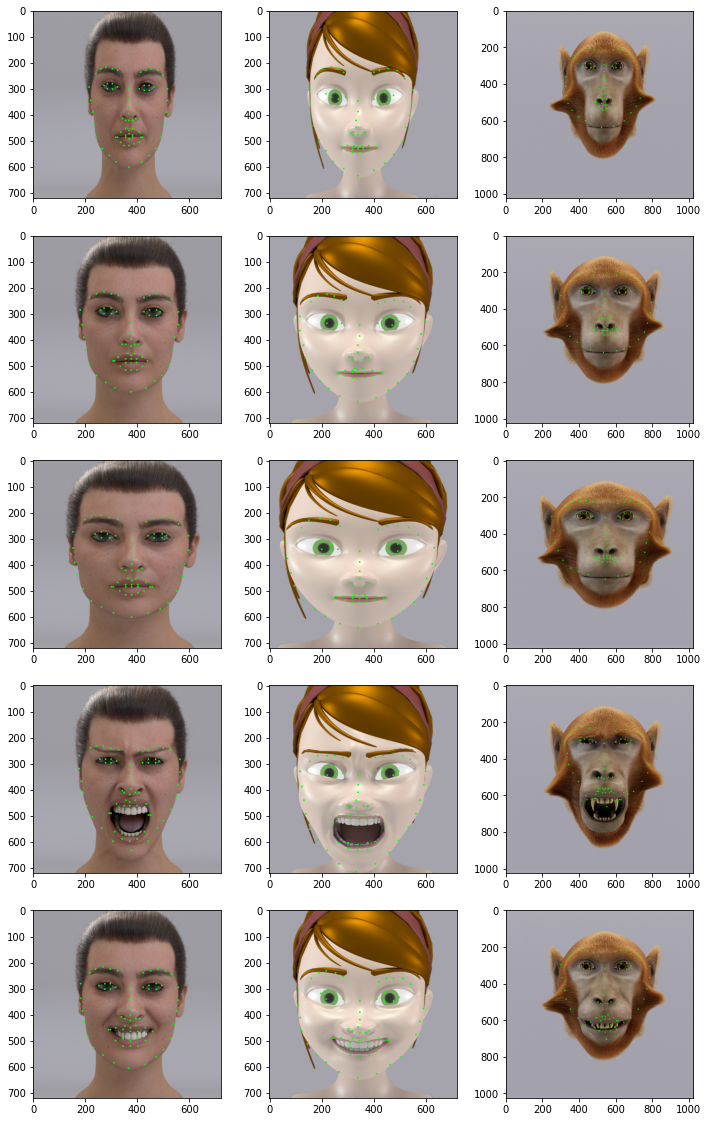

In [3]:
display_images(images, preds, n_max_col=3, lmk_size=7)

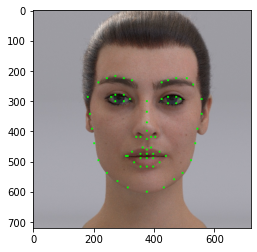

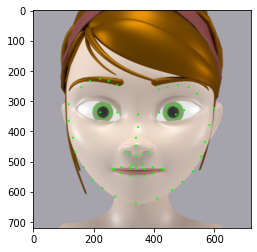

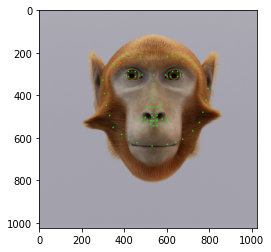

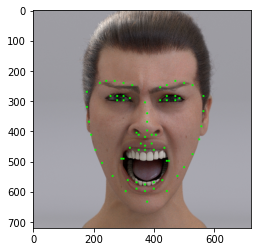

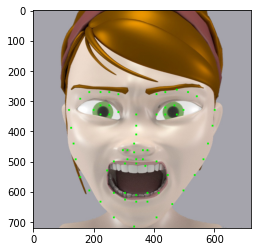

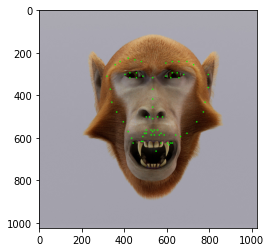

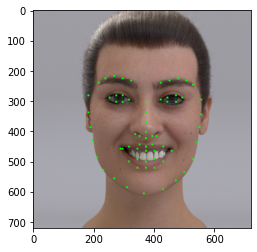

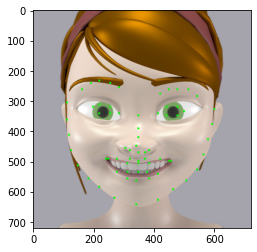

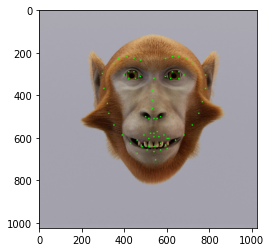

In [4]:
img_names = ["louise_neutral_FAN_LMK.png", "mery_neutral_FAN_LMK.png", "monkey_neutral_FAN_LMK.png",
             "louise_angry_FAN_LMK.png", "mery_angry_FAN_LMK.png", "monkey_angry_FAN_LMK.png",
             "louise_happy_FAN_LMK.png", "mery_happy_FAN_LMK.png", "monkey_happy_FAN_LMK.png"]
img_idx = [3, 4, 5, 9, 10, 11, 12, 13, 14]
for i, name in zip(img_idx, img_names):
    display_image(images[i], preds[i], lmk_size=7, save=True, save_name=name)

# Train Norm-reference encoding on BFS using FAN landmarks as input

### Get parameters

In [5]:
# define configuration
config_path = 'NR_08_BFS_FAN_lmks_m0001.json'

# load config
config = load_config(config_path, path='../../configs/norm_reference')

### load training data

In [6]:
# load all neutral pose to train the reference vectors
config['train_avatar'] = 'all_identities'
config['train_expression'] = ['Neutral']
ref_training_data = load_data(config, get_raw=True)
ref_training_data[0] = np.array(ref_training_data[0]).astype(int)
print("shape training_data[0]", np.shape(ref_training_data[0]))

# load all expressions on the human head to train the tuning directions
config['train_avatar'] = 'Louise'
config['train_expression'] = ['full']
expr_training_data = load_data(config, get_raw=True)
expr_training_data[0] = np.array(expr_training_data[0]).astype(int)
print("shape expr_training_data[0]", np.shape(expr_training_data[0]))

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:443: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 15/15 [00:00<00:00, 156.40it/s]
/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:443: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)


shape training_data[0] (15, 720, 720, 3)


100%|██████████| 7/7 [00:00<00:00, 152.47it/s]

shape expr_training_data[0] (7, 720, 720, 3)


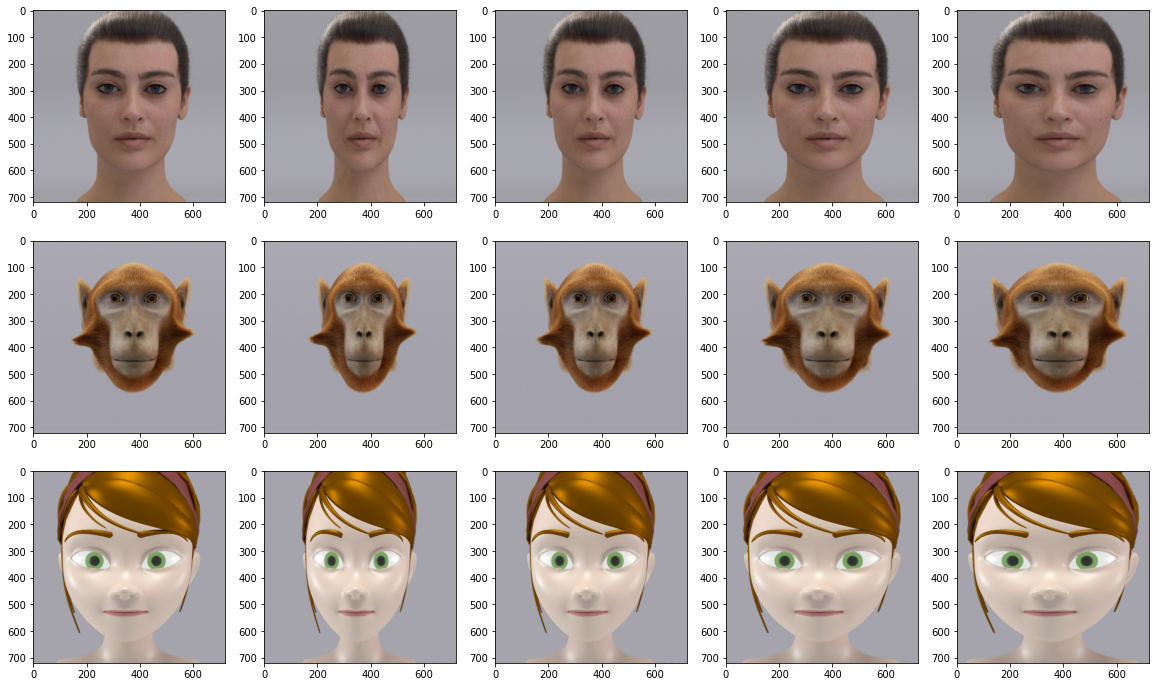

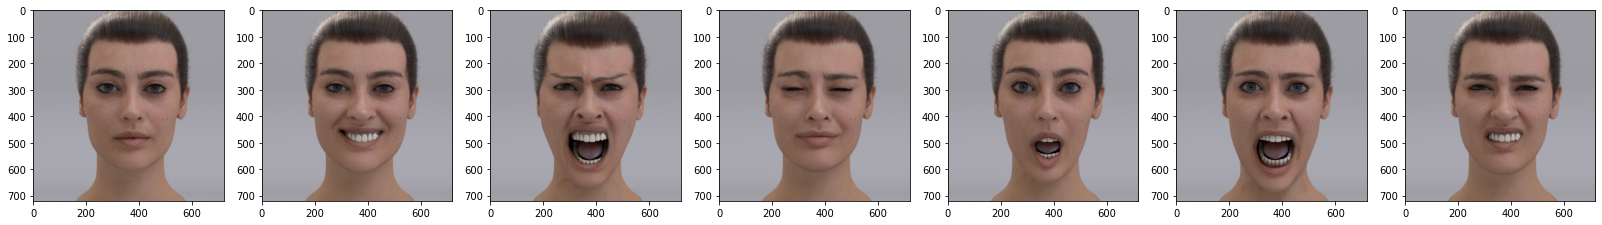

In [7]:
display_images(ref_training_data[0], n_max_col=5)
display_images(expr_training_data[0])

## Predict LMKS using facial-alignment (FAN) network

In [8]:
def predict_lmks(data):
    # predict landmarks
    lmks_pos = []
    for i, img in enumerate(tqdm.tqdm(data)):
        lmk_preds = fa.get_landmarks(img)
        if lmk_preds is None:
            print(i, "no face detected")
            lmk_preds = np.zeros((1, 68, 2))
        lmks_pos.append(lmk_preds)
    return np.squeeze(np.array(lmks_pos))

In [9]:
ref_lmks_pos = predict_lmks(ref_training_data[0])
expr_lmks_pos = predict_lmks(expr_training_data[0])

100%|██████████| 7/7 [00:05<00:00,  1.28it/s]


In [10]:
print("shape ref_lmks_pos", np.shape(ref_lmks_pos))
print("shape expr_lmks_pos", np.shape(expr_lmks_pos))
n_features = np.shape(ref_lmks_pos)[1] * np.shape(ref_lmks_pos)[2]
print("n_features:", n_features)

shape ref_lmks_pos (15, 68, 2)
shape expr_lmks_pos (7, 68, 2)
n_features: 136


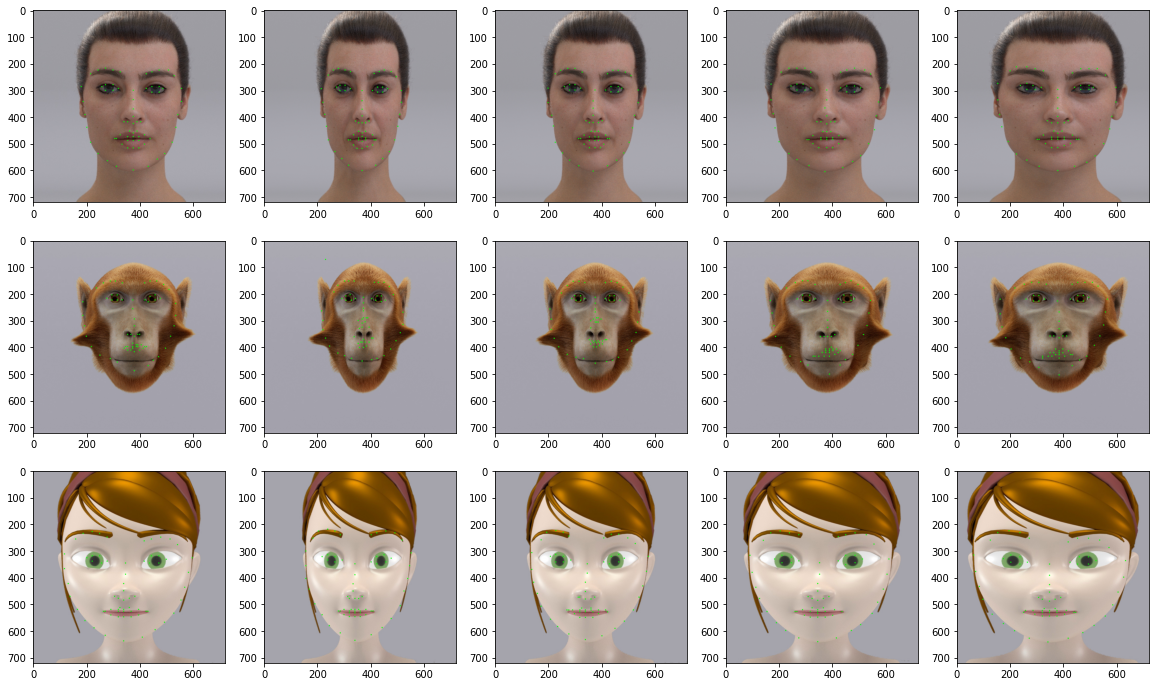

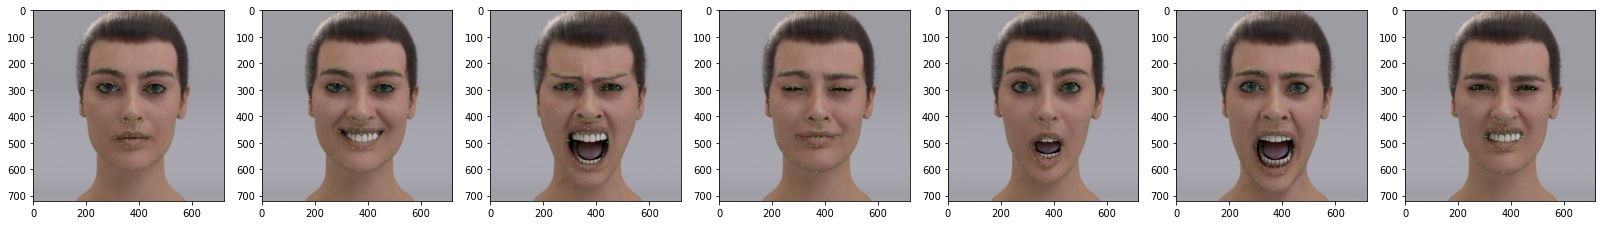

In [11]:
# display predicted lmks
display_images(ref_training_data[0], lmks=ref_lmks_pos, n_max_col=5)
display_images(expr_training_data[0], lmks=expr_lmks_pos)

In [12]:
# # create subset of lmks
# sub_lmks = ref_lmks_pos[0]
# print("shape sub_lmks", np.shape(sub_lmks))
# # sub_lmks = [sub_lmks[17, :]]  # left-eyebrow ext
# # sub_lmks = [sub_lmks[21, :]]  # left-eyebrow int
# # sub_lmks = [sub_lmks[22, :]]  # right-eyebrow int
# # sub_lmks = [sub_lmks[26, :]]  # right-eyebrow ext
# # sub_lmks = [sub_lmks[41, :]]  # under left_eye
# # sub_lmks = [sub_lmks[46, :]]  # under right_eye
# # sub_lmks = [sub_lmks[48, :]]  # left mouth corner
# # sub_lmks = [sub_lmks[51, :]]  # top mouth
# # sub_lmks = [sub_lmks[54, :]]  # right mouth corner
# # sub_lmks = [sub_lmks[57, :]]  # lower mouth
# print("shape sub_lmks", np.shape(sub_lmks))
# print("shape ref_traininf_data[0]", np.shape(ref_training_data[0]))
# display_images([ref_training_data[0][0]], lmks=[sub_lmks], size_img=6)

shape sub_ref_lmks_pos (15, 10, 2)
shape sub_expr_lmks_pos (7, 10, 2)


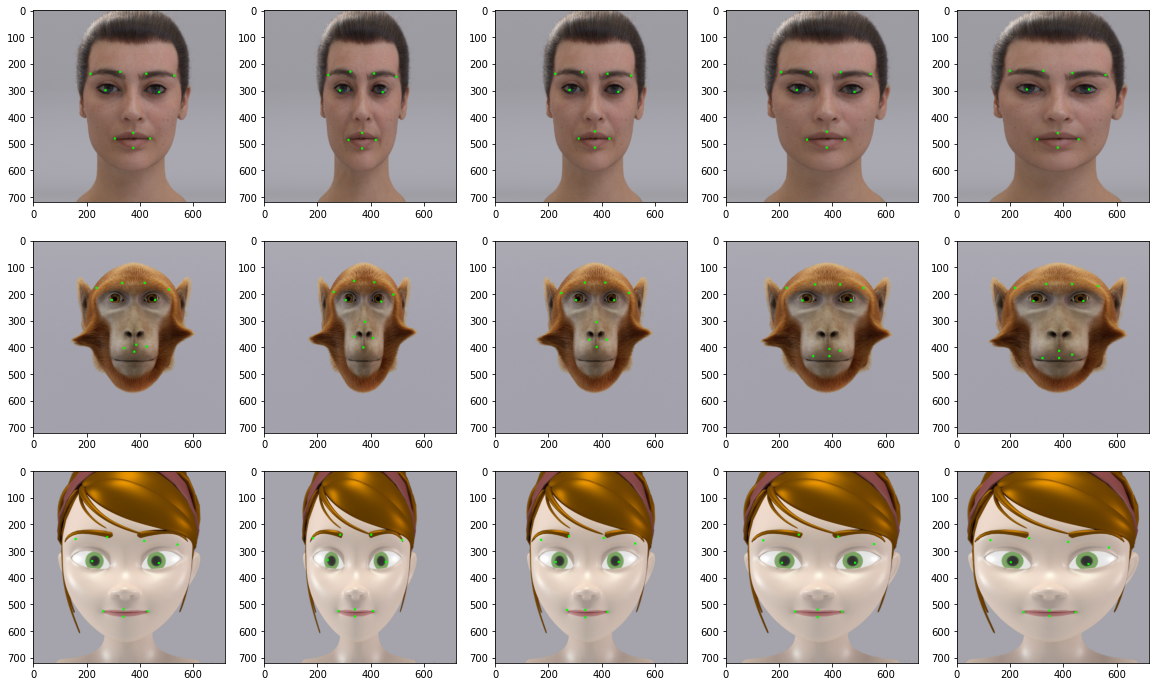

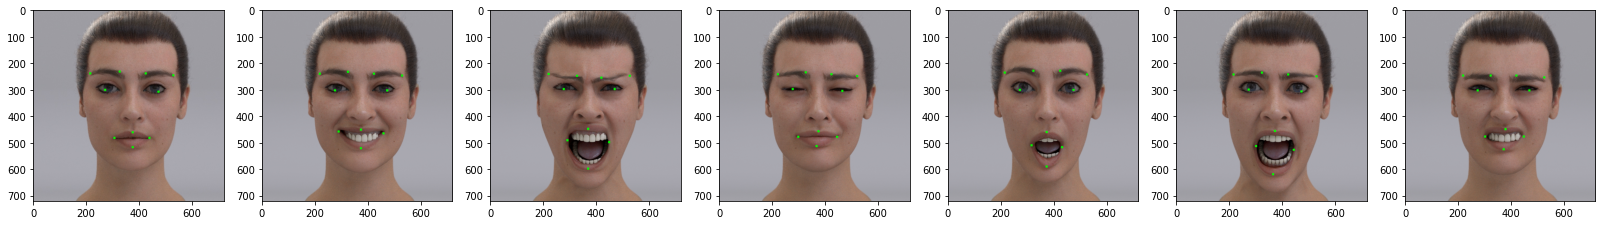

In [13]:
sub_idx = [17, 21, 22, 26, 48, 51, 54, 57, 41, 46]
sub_ref_lmks_pos = ref_lmks_pos[:, sub_idx, :]
sub_expr_lmks_pos = expr_lmks_pos[:, sub_idx, :]
print("shape sub_ref_lmks_pos", np.shape(sub_ref_lmks_pos))
print("shape sub_expr_lmks_pos", np.shape(sub_expr_lmks_pos))
display_images(ref_training_data[0], lmks=sub_ref_lmks_pos, n_max_col=5, lmk_size=9)
display_images(expr_training_data[0], lmks=sub_expr_lmks_pos, lmk_size=9)

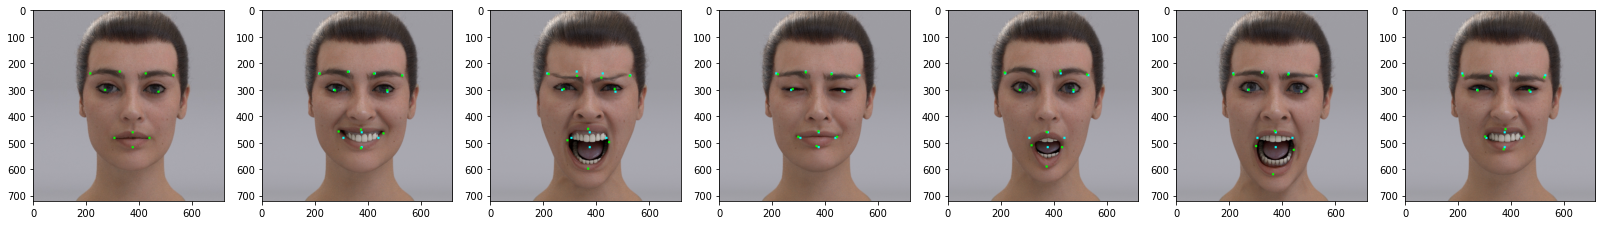

In [14]:
# compare ref to expr lmks
display_images(expr_training_data[0], lmks=sub_expr_lmks_pos, ref_lmks=sub_expr_lmks_pos[0], lmk_size=9)

# Train Norm-Reference Model

In [15]:
# train ref model
ref_vector = sub_ref_lmks_pos[0]
print("ref_vector", np.shape(ref_vector))

ref_vector (10, 2)


In [16]:
# train tuning vectors
tun_vectors = sub_expr_lmks_pos - np.repeat(np.expand_dims(ref_vector, axis=0), len(sub_expr_lmks_pos), axis=0)
print("shape tun_vectors", np.shape(tun_vectors))

shape tun_vectors (7, 10, 2)


In [17]:
# compute projections
def predict_NR(input, ref_vector, tun_vectors, nu=1, verbose=False):
    projections = []

    # normalize by norm of each landmarks
    norm_t = np.linalg.norm(tun_vectors, axis=2)

    # for each images
    for i in range(len(input)):
        # compute relative vector (difference)
        diff = input[i] - ref_vector
        proj = []
        # for each category
        for j in range(len(tun_vectors)):
            proj_length = 0
            # for each landmarks
            for k in range(len(ref_vector)):
                if norm_t[j, k] != 0.0:
                    f = np.dot(diff[k], tun_vectors[j, k]) / norm_t[j, k]
                    f = np.power(f, nu)
                else:
                    f = 0
                proj_length += f
            # ReLu activation
            if proj_length < 0:
                proj_length = 0
            proj.append(proj_length)
        projections.append(proj)

    projections = np.array(projections)

    if verbose:
        print("projections", np.shape(projections))
        print(projections)

    return np.argmax(projections, axis=1)

In [18]:
preds = predict_NR(sub_expr_lmks_pos, ref_vector, tun_vectors, nu=config['nu'], verbose=True)
print("shape preds", np.shape(preds))
print(preds)

projections (7, 7)
[[  0.      0.      0.      0.      0.      0.      0.   ]
 [  0.     89.615  26.457  74.297   0.      0.     83.679]
 [  0.    116.991 190.057  45.776  84.169 173.777 141.038]
 [  0.     46.029  37.742  65.889   0.     15.331  45.922]
 [  0.     12.508 100.135   0.    175.957 127.256   8.531]
 [  0.     59.339 185.253   0.    166.474 205.952  81.764]
 [  0.     75.492  65.08   71.266   0.     53.949  90.358]]
shape preds (7,)
[0 1 2 3 4 5 6]


## TEST model on BFS

In [19]:
test_data = load_data(config, train=False, get_raw=True)
test_data[0] = np.array(test_data[0]).astype(int)

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:443: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
 70%|██████▉   | 73/105 [00:00<00:00, 118.75it/s]


ValueError: Image is None, control given path: /Users/michaelstettler/PycharmProjects/BVS/data/BasicFaceShape/img/Mery_Sad.jpeg

In [ ]:
display_images(test_data[0])

In [ ]:
# predict lmks on test_data
test_lmks_pos = predict_lmks(test_data[0])

In [ ]:
print("shape test_lmks_pos", np.shape(test_lmks_pos))
sub_test_lmks_pos = test_lmks_pos[:, sub_idx, :]
print("shape sub_test_lmks_pos", np.shape(sub_test_lmks_pos))
nr_test_preds = predict_NR(sub_test_lmks_pos, ref_vector, tun_vectors, nu=config['nu'])

In [ ]:
corrects = [1 for i in range(len(nr_test_preds)) if nr_test_preds[i] == test_data[1][i]]
n_corrects = np.sum(corrects)
accuracy = n_corrects / len(nr_test_preds)
print("accuracy:", accuracy)

In [ ]:
hum_corrects = [1 for p, pred in enumerate(nr_test_preds[:35]) if pred == test_data[1][p]]
n_hum_corrects = np.sum(hum_corrects)
hum_accuracy = n_hum_corrects / len(nr_test_preds[:35])
print("hum_accuracy:", hum_accuracy)

In [ ]:
monk_corrects = [1 for p, pred in enumerate(nr_test_preds[35:70]) if pred == test_data[1][p + 35]]
n_monk_corrects = np.sum(monk_corrects)
monk_accuracy = n_monk_corrects / len(nr_test_preds[35:70])
print("monk_accuracy:", monk_accuracy)

In [ ]:
mery_corrects = [1 for p, pred in enumerate(nr_test_preds[70:]) if pred == test_data[1][p + 70]]
n_mery_corrects = np.sum(mery_corrects)
mery_accuracy = n_mery_corrects / len(nr_test_preds[70:])
print("mery_accuracy:", mery_accuracy)